# Deploy and Test a TensorFlow Lite for Microcontrollers model

This notebook builds on the previous one, which demonstrated the process of training and optimizing a neural network using TensorFlow and converting it for TensorFlow Lite for Microcontrollers.

The objective now is to deploy, test, and validate our model on the B-L4S5I-IOT01A Discovery kit from STMicroelectronics.

To deploy this model on the board, we'll use [STM32CubeMX](https://www.st.com/en/development-tools/stm32cubemx.html) (v6.11.1) which is "a graphical tool that allows a very easy configuration of STM32 microcontrollers and microprocessors, as well as the generation of the corresponding initialization C code". We also are going to use its X-CUBE-AI (v9.0.0) Expansion Package for Artificial Intelligence (AI). Finally, the IDE used for developing, debugging and flashing is STM32CubeIDE (v1.15.1).

The first step is to follow the X-CUBE-AI [User manual](https://www.st.com/resource/en/user_manual/um2526-getting-started-with-xcubeai-expansion-package-for-artificial-intelligence-ai-stmicroelectronics.pdf). When adding the X-CUBE-AI component, we need to make sure we select *ApplicationTemplate* as the Device Application. Then when asked to upload a pretrained DL model file, we can upload the sine_model.tflite file generated earlier. Note that the name we give to our model will impact the files and functions names in the library.

Once the code is generated, we can open the project in STM32CubeIDE (the name of the project will impact some files names) . We should have the following tree structure (the relevant folders have been expanded):
```
├── Includes
├── Core
│   ├── Inc
│   ├── Src
│   │   ├── main.c
│   │   ├── stm3214xx_hal_msp.c
│   │   ├── stm3214xx_it.c
│   │   ├── syscalls.c
│   │   ├── sysmem.c
│   │   └── system_stm32l4xx.c
|   └── Startup
├── Drivers
├── X-CUBE-AI
│   ├── App
│   │   ├── app_x-cube-ai.c
│   │   ├── app_x-cube-ai.h
│   │   ├── sine_model_config.h
│   │   ├── sine_model_data.c
│   │   ├── sine_model_data.h
│   │   ├── sine_model_data_params.c
│   │   ├── sine_model_data_params.h
│   │   ├── sine_model.c
│   │   ├── sine_model.h
│   │   └── sine_model_generate_report.txt
│   ├── constants_ai.h
│   └── LICENSE.txt
├── Debug
├── Middlewares
├── SineModelCubelDE.ioc
├── SineModelCubelDE_Debug.launch
├── STM32L4S5VITX_FLASH.Id
└── STM32L4S5VITX_RAM.Id

```

Note : The syscalls.c file might not be generated. If it's the case, copy the syscalls.c file from another project using the same board.

## Configure the I/O

To be able to print data on the serial port like the model's output, two steps are mandatory:
- Enable the float formatting support:
  - Using the IDE Settings from "Project > Properties > C/C++ Build > Settings > Tool Settings > MCU Settings"
  - Or add manually "-u _printf_float" in linker flags (LDFLAGS).
- Add an implementation of the __io_putchar function:

  ```c
  /* USER CODE BEGIN 4 */
  int __io_putchar(int ch){
    HAL_UART_Transmit(&huart1, (uint8_t *) &ch, 1, HAL_MAX_DELAY);
    return ch;
  }
  /* USER CODE END 4 */
  ```



## Configure and run the model

Now we can configure the input and output of our model. The goal here is to write the output of our model to a csv file and visualize the result in this notebook.
First let's create the input data. In our case we need to add code to the already created `acquire_and_process_data` function. We're going to run our model with 1000 different values between 0 and 2π :
```c
#define SAMPLES 1000
float x_values[SAMPLES];
int current_sample = 0;


int acquire_and_process_data(ai_i8* data[])
{
  // The model expects a single float input
  float x = x_values[current_sample];

  // Retrieve the input buffer pointer
  ai_float* input_data = (ai_float*)data[0];

  // Fill the input buffer with the test value
  input_data[0] = x;

  return 0;
}
```

The initialization of our `x_values` array will be done in the initialization function of our model (don't forget to include the `math.h` library in order to use the `M_PI` constant):
```c
void MX_X_CUBE_AI_Init(void)
{
    /* USER CODE BEGIN 5 */
  printf("\r\nSINE_PREDICTION_APP - initialization\r\n");


  // Generate the x values
  for (int i = 0; i < SAMPLES; i++)
  {
    x_values[i] = (float)i * 2 * M_PI / SAMPLES;
  }

  ai_boostrap(data_activations0);
    /* USER CODE END 5 */
}
```
In order to read our CSV later, we need to define a header. This header will be printed right before starting the model's inferences:
```c
void MX_X_CUBE_AI_Process(void)
{
    /* USER CODE BEGIN 6 */
  int res = -1;

  printf("SINE_PREDICTION_APP - run - main loop\r\n");

  if (sine_model) {
    // Mark the beginning of the CSV log
    printf("BeginCSVLog\r\n");
    // Print the header
    printf("x_input,y_prediction,y_actual\r\n");

    do {
      /* 1 - acquire and pre-process input data */
      res = acquire_and_process_data(data_ins);
      /* 2 - process the data - call inference engine */
      if (res == 0)
        res = ai_run();
      /* 3- post-process the predictions */
      if (res == 0)
        res = post_process(data_outs);
    } while (res==0);
  }

  if (res) {
    // Mark the end of the CSV log
    printf("EndCSVLog\r\n");
    ai_error err = {AI_ERROR_INVALID_STATE, AI_ERROR_CODE_NETWORK};
    ai_log_err(err, "Process has FAILED");
  }
    /* USER CODE END 6 */
}
```
Finally, in order to print every input, prediction and expected value, we need to add some code to the `post_process` function:
```c
int post_process(ai_i8* data[])
{
    // The model outputs a single float value
    ai_float* output_data = (ai_float*)data[0];

    // Retrieve the model's prediction
    float prediction = output_data[0];

    // Print the input and prediction
    float actual_value = sin(x_values[current_sample]);
    printf("%f,%f,%f\r\n", x_values[current_sample], prediction, actual_value);

    // Increment the sample index and check if we have reached the end
    if (++current_sample >= SAMPLES) {
      return -1;
    }
    return 0;
}
```
We can now run the code on the board and monitor the data sent on the serial port using a tool like Tera Term or Putty, while making sure to set the following parameters (the serial port may vary):



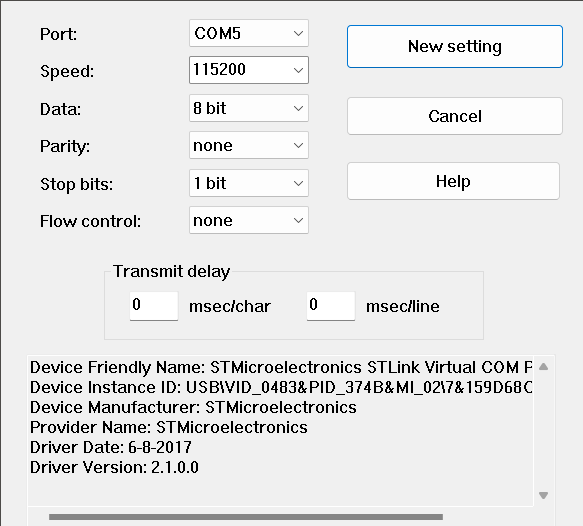

If using Tera Term, after setting the correct parameters, we can go to "Setup > Save Setup" to prevent from having to configure the serial monitor each time we launch Tera Term

## Export the model results

To create our CSV file, we are using the serial monitor log function. Here will be explained how to do it with Tera Term.
We need to create a file at a location we want, here it will be "sine_prediction.log".
On Tera Term, we go to "File > Log", select the file we created, and set the write mode to "New/Overwrite".
Now that the logging has started, we can either flash the program to the board, or just click on the RESET button of the board to re execute the code.

The data should be on your file and we can open it to make sure that there is only CSV data between the BeginCSVLog and EndCSVLog markers (for example, if the program has encountered errors during execution).

We can now upload the log file in the notebook.

Once the file is uploaded, we are going to filter the log file to only keep the CSV data:


In [1]:
import pandas as pd
import os

FILE_NAME = 'sine_prediction.log'
START_MARKER = 'BeginCSVLog'
END_MARKER = 'EndCSVLog'

# Check if the file exists, otherwise raise an error
if not os.path.exists(FILE_NAME):
    raise FileNotFoundError(f"File '{FILE_NAME}' not found.")

collect_lines = False
csv_lines = []

# Read the file line by line to remove the non-csv data
with open(FILE_NAME, 'r') as file:
    for line in file:
        if START_MARKER in line:
            collect_lines = True
            continue
        if END_MARKER in line:
            collect_lines = False
        if collect_lines:
            csv_lines.append(line)

csv_content = ''.join(csv_lines)

# Load the collected lines into a DataFrame
from io import StringIO

df = pd.read_csv(StringIO(csv_content))

# Display the first and last few rows to understand the structure
print(df)

      x_input  y_prediction  y_actual
0    0.000000     -0.026285  0.000000
1    0.006283     -0.019417  0.006283
2    0.012566     -0.012553  0.012566
3    0.018850     -0.005692  0.018848
4    0.025133      0.001164  0.025130
..        ...           ...       ...
995  6.251770     -0.135169 -0.031411
996  6.258052     -0.130477 -0.025130
997  6.264336     -0.125786 -0.018849
998  6.270619     -0.121096 -0.012566
999  6.276902     -0.116409 -0.006283

[1000 rows x 3 columns]


The data can now be displayed and we can compare the predictied sine and the expected one:

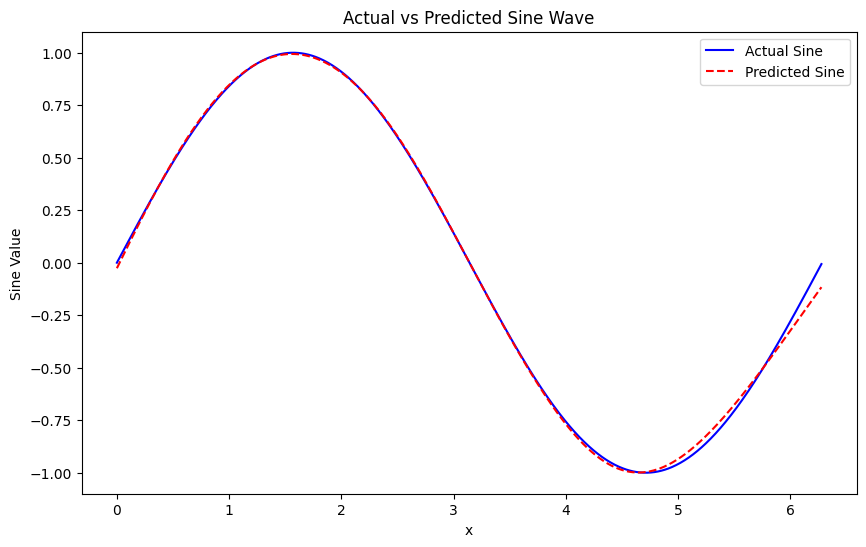

In [2]:
import matplotlib.pyplot as plt

# Plotting the sine waves
plt.figure(figsize=(10, 6))

# Plot actual sine wave
plt.plot(df['x_input'], df['y_actual'], label='Actual Sine', color='blue')

# Plot predicted sine wave
plt.plot(df['x_input'], df['y_prediction'], label='Predicted Sine', color='red', linestyle='--')

# Add labels and title
plt.xlabel('x')
plt.ylabel('Sine Value')
plt.title('Actual vs Predicted Sine Wave')
plt.legend()

# Show plot
plt.show()

The predicted sine wave appears to be really accurate but lacks precision for `x>4`. It confirms that the model can still be improved.

## Validate the model using STM32CubeMX

Up to now, we've done our tests manually, injecting a series of input values directly into the code and retrieving the output to check that the model is working properly. Now we're going to use a tool provided directly by STM32CubeMX: the "validate on target" function.

In order to do that, we need to configure a new .ioc file and in order to do that we can follow the X-CUBE-AI [User manual](https://www.st.com/resource/en/user_manual/um2526-getting-started-with-xcubeai-expansion-package-for-artificial-intelligence-ai-stmicroelectronics.pdf) like earlier. But this time, when adding the X-CUBE-AI component, we need to make sure to select *Validation* as the Device Application (we can also follow [this tutorial](https://wiki.st.com/stm32mcu/wiki/AI:How_to_automatize_code_generation_and_validation_with_X-CUBE-AI_CLI) but it suggests creating a project in STM32CubeIDE, which is not necessary here).

The new tab "Platform Settings" allows us to configure how we want to communicate.   

In the model tab, we can import the .tflite file like earlier. But in this case we need to give inputs and expected outputs so that this data is used to validate the model on the board. We can use the data from the log we uploaded earlier:

In [3]:
import numpy as np

# Define the required shape (excluding batch size)
shape = (1, 1, 1)  # (height, width, channels)
num_samples = 1000  # Number of samples in the CSV
input_data = df['x_input'].values.astype(np.float32)
output_data = df['y_actual'].values.astype(np.float32)


To be able to give it to our model, the data needs to be reshaped to the required shape (NUMBER_OF_SAMPLES, 1, 1, 1). We can then save it to a numpy file:

In [4]:
# Reshape the data to the required shape
input_data = input_data.reshape(num_samples, *shape)
output_data = output_data.reshape(num_samples, *shape)

# Print the reshaped data and its shape to verify
print("Loaded input data shape:", input_data.shape)  # Should print (1000, 1, 1, 1)
print("Loaded output data shape:", output_data.shape)  # Should print (1000, 1, 1, 1)

# Save the data
# Create the folder if it doesn't exist
folder_name = 'iovalidation'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

# Save the data files in the folder
np.save(os.path.join(folder_name, 'input_data.npy'), input_data)
np.save(os.path.join(folder_name, 'output_data.npy'), output_data)


Loaded input data shape: (1000, 1, 1, 1)
Loaded output data shape: (1000, 1, 1, 1)


We can now download these two files and select them as validation input and validation ouput in CubeMX.
Once that's done, we can start the validation by clicking on "Validate on target" and making sure the following configuration is set (we can adapt it to the COM port and the toolchain/IDE used):

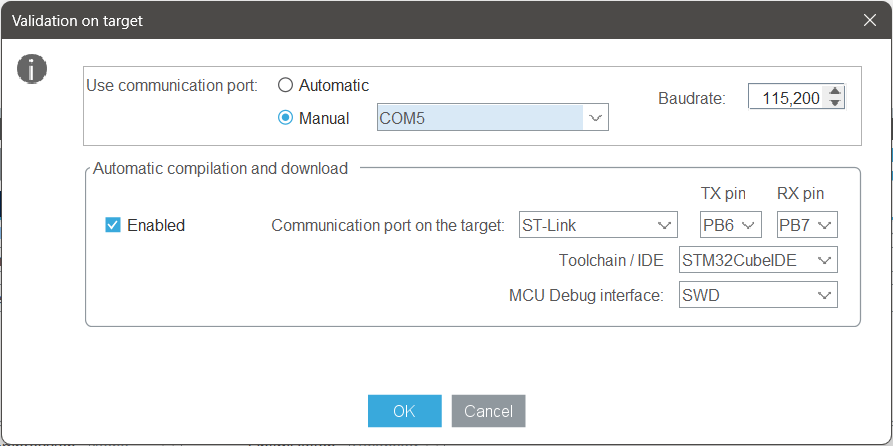



Once the validation is done, we can check the report created and see the evaluation report :

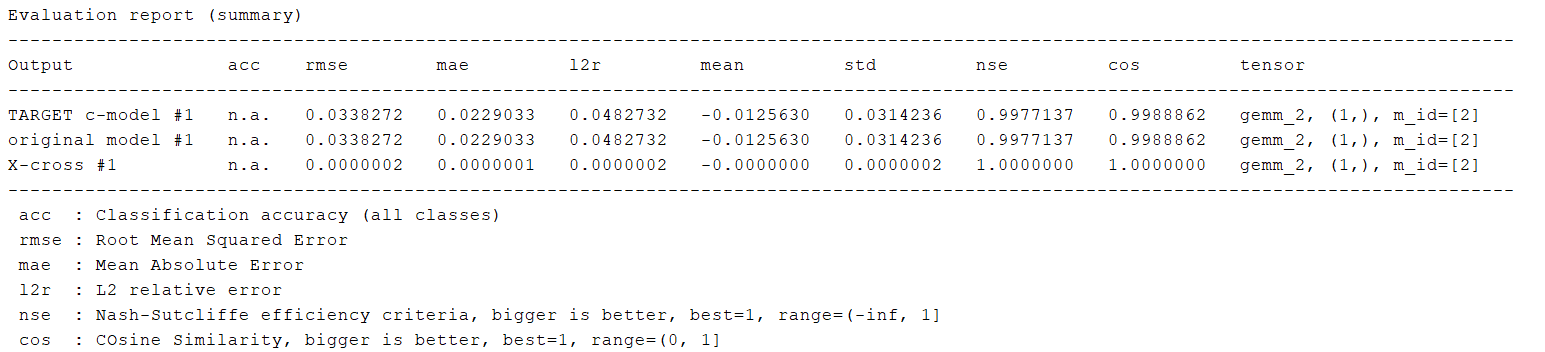

The values such as RMSE and MAE can confirm that the accuracy of our model is the same on target as it was in the notebook

## System performence and power/energy measurements

Here, the goal is firstly to use the system-performance application generated using STM32Cube.AI which allows direct measurement of the inference time on the target. Secondly, we'll modify this application to run power and energy measurements in an optimal configuration. In order to do that we are following a [tutorial](https://wiki.st.com/stm32mcu/wiki/AI:How_to_measure_machine_learning_model_power_consumption_with_STM32Cube.AI_generated_application) and adapting it to our board.
The performance measurement part is quite straightforward and doesn't need much tweaks to work on our board. We just need to make sure to keep the correct UART pins:


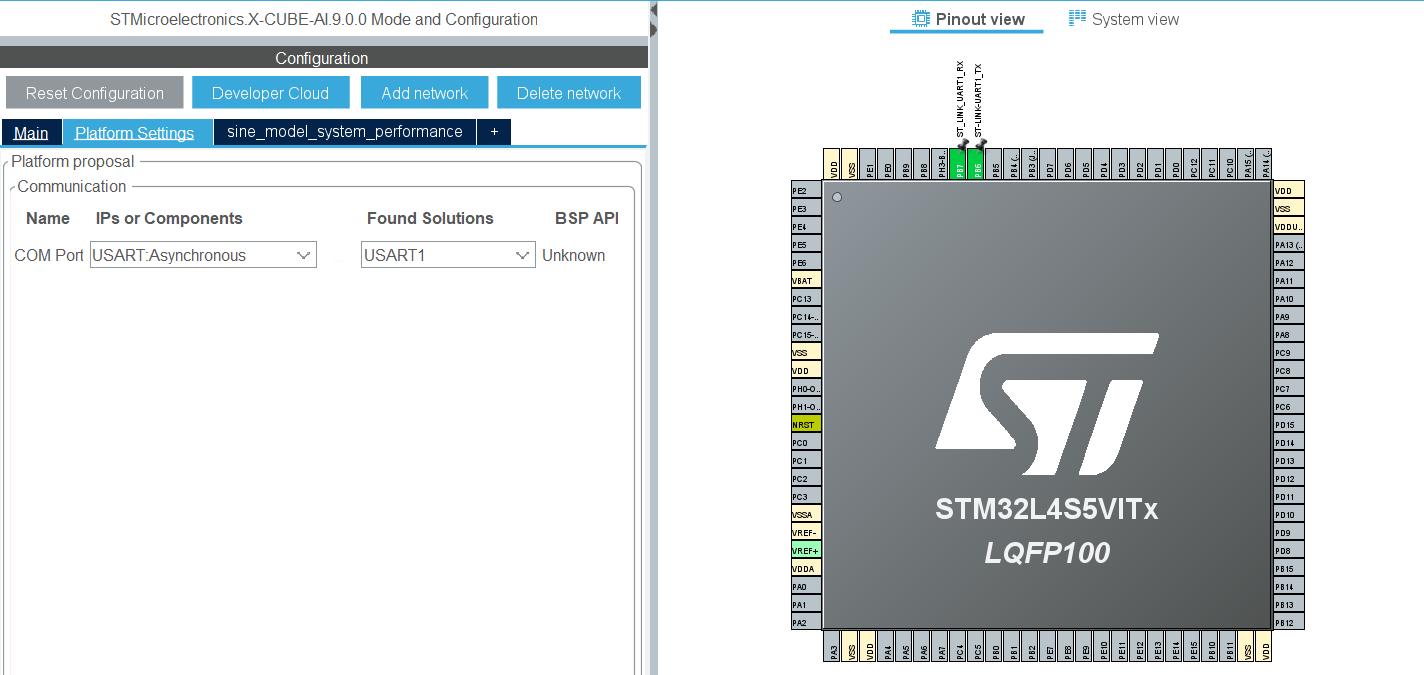

Once we generated the code, we can add the necessary code snippets to our project (and don't forget to adapt the GPIO IDs and UART handle) and build/flash the code to the board. WE can open Tera Term to observe the output:
```
#
# AI system performance 7.1
#
Compiled with GCC 12.3.1
STM32 device configuration...
 Device       : DevID:0x0470 (STM32L4R/S) RevID:0x101f
 Core Arch.   : M4 - FPU  used
 HAL version  : 0x010d0400
 SYSCLK clock : 120 MHz
 HCLK clock   : 120 MHz
 FLASH conf.  : ACR=0x00000605 - Prefetch=False $I/$D=(True,True) latency=5
 Timestamp    : SysTick + DWT (delay(1)=1.008 ms)

AI platform (API 1.1.0 - RUNTIME 9.0.0)
Discovering the network(s)...

Found network "sine_model_system_performance"
Creating the network "sine_model_system_performance"..
Initializing the network
Network informations...
 model name         : sine_model_system_performance
 model signature    : 0x6e5e4875bd84cbc1e1ebba21b83541a9
 model datetime     : Thu Jun 20 11:47:33 2024
 compile datetime   : Jun 20 2024 11:59:56
 tools version      : 9.0.0
 complexity         : 353 MACC
 c-nodes            : 5
 map_activations    : 1
  [0]  @0x20000AA0/128
 map_weights        : 1
  [0]  @0x800A220/1284
 n_inputs/n_outputs : 1/1
  I[0] (1,1,1,1)1/float32 @0x20000ADC/4
  O[0] (1,1,1,1)1/float32 @0x20000AA0/4

Running PerfTest on "sine_model_system_performance" with random inputs (16 iterations)...
................

Results for "sine_model_system_performance", 16 inferences @120MHz/120MHz (complexity: 353 MACC)
 duration     : 0.088 ms (average)
 CPU cycles   : 10659 (average)
 CPU Workload : 0% (duty cycle = 1s)
 cycles/MACC  : 30.19 (average for all layers)
 used stack   : 376 bytes
 used heap    : 0:0 0:0 (req:allocated,req:released) max=0 cur=0 (cfg=3)
 observer res : 104 bytes used from the heap (5 c-nodes)

 Inference time by c-node
  kernel  : 0.066ms (time passed in the c-kernel fcts)
  user    : 0.008ms (time passed in the user cb)

 c_id  type                id       time (ms)
 ---------------------------------------------------
 0     DENSE               0          0.014  21.36 %
 1     NL                  0          0.004   7.14 %
 2     DENSE               1          0.033  50.29 %
 3     NL                  1          0.004   7.14 %
 4     DENSE               2          0.009  14.06 %
 -------------------------------------------------
                                      0.066 ms
```
We can see that average inference time of 0.088 ms is quite efficient for a model running on a microcontroller at 120 MHz. This indicates that the model is lightweight as expected.
Also the stack usage of 376 bytes suggests efficient memory usage.

The next step is going to run power/energy measurments. Since the power shield used in the tutorial isn't compatible with our board, we are going to acquire the data through the STLINK-V3PWR probe.